In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stability(file_name):
    responses = np.load(f"test_cache/permute/{file_name}.npz")
    for key in ["train", "finer", "timer", "total_timer"]:
        try:
            train_averaged = np.average(responses[key], axis = 0)[:-25]
            train_std = np.std(responses[key], axis = 0)[:-25]
            plt.plot(train_averaged, color = "blue")
            plt.fill_between(range(len(train_averaged)), np.clip(train_averaged - train_std, 0, 1), np.clip(train_averaged + train_std, 0, 1),
                            color='blue', alpha=0.1)
            plt.xlabel("Length")
            plt.ylabel("Performance")
            plt.title(f"File - {file_name} + {key}")
            plt.show()
        except:
            pass

In [2]:
# plot_stability("refactored_permute_config-trained-ch2-1000-ch2_end_deplete_500_5_20")

In [3]:
# plot_stability("refactored_permute_config-trained-ch2-1000-ch3_end_deplete_500_5_20")

In [4]:
# plot_stability("refactored_permute_config-trained-ch2-1000-ch3_end_deplete_500_50_20")

In [5]:
# plot_stability("refactored_permute_config-trained-ch2-1000-ch2_end_deplete_500_50_20")

In [6]:
# plot_stability("refactored_permute_config-trained-ch2-1000-ch2,ch3_end deplete_500_5_20")

In [7]:
# plot_stability("refactored_permute_config-trained-ch2-1000-ch2,ch3_end deplete_500_50_20")

In [8]:
# plot_stability("permute_end deplete_5000_5_50")

In [9]:
# plot_stability("permute_end deplete_5000_50_50")

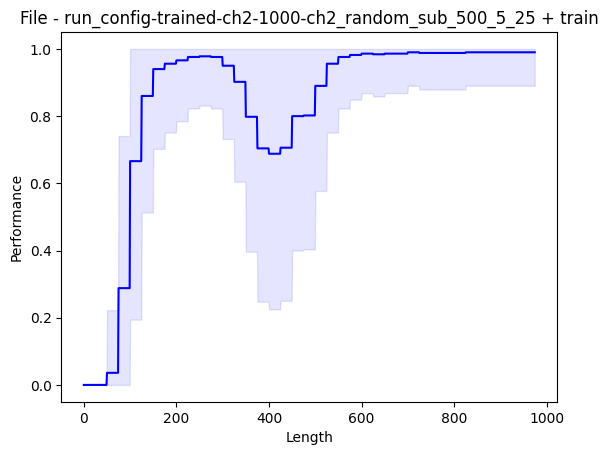

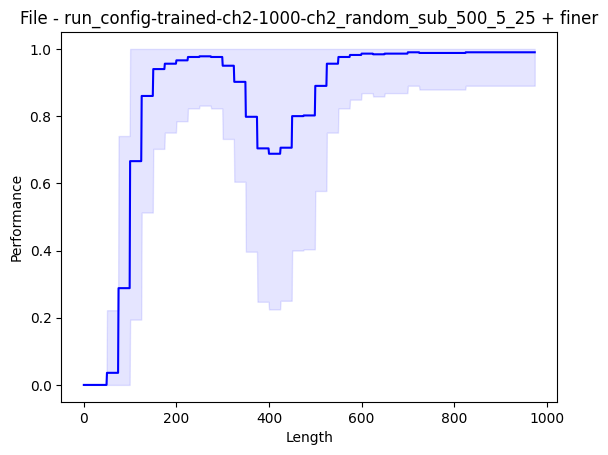

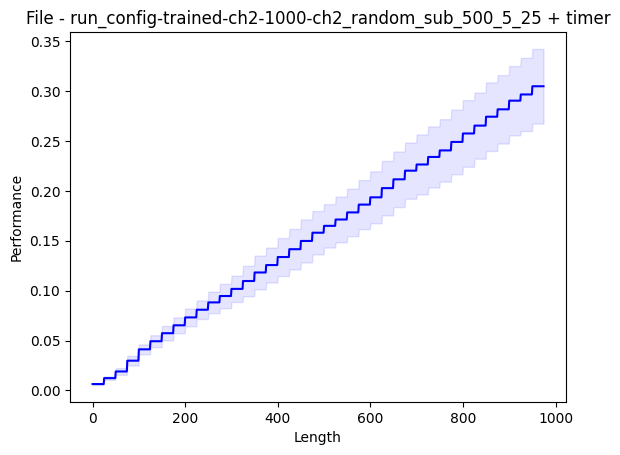

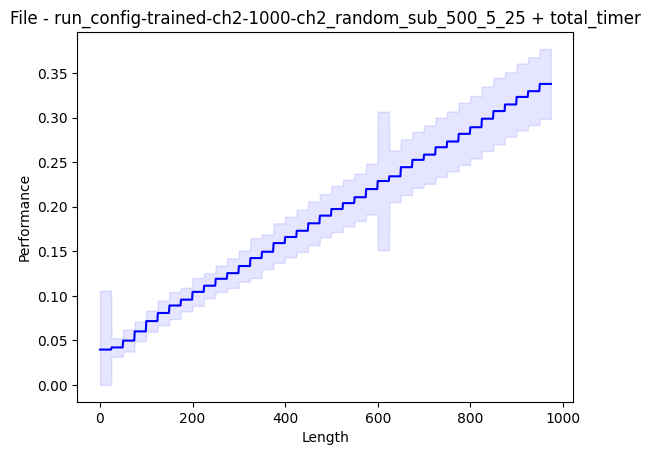

In [13]:
plot_stability("run_config-trained-ch2-1000-ch2_random_sub_500_5_25")

In [14]:
responses = np.load(f"/home/pholur/dna2vec/evaluate/test_cache/permute/run_config-trained-all-all_random_sub_100_50_25.npz")
print("Accuracy: ", np.sum(responses["finer"][:, 800:1000])/(200*responses["finer"].shape[0]))

Accuracy:  0.9333333333333333


In [1]:
plot_stability("run_config-trained-all-all_random_sub_100_5_25")

NameError: name 'plot_stability' is not defined

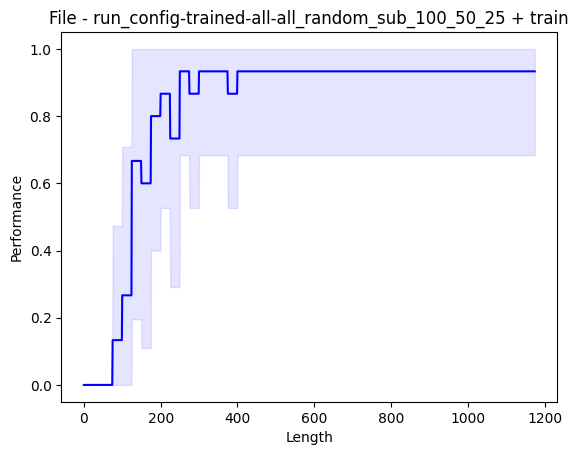

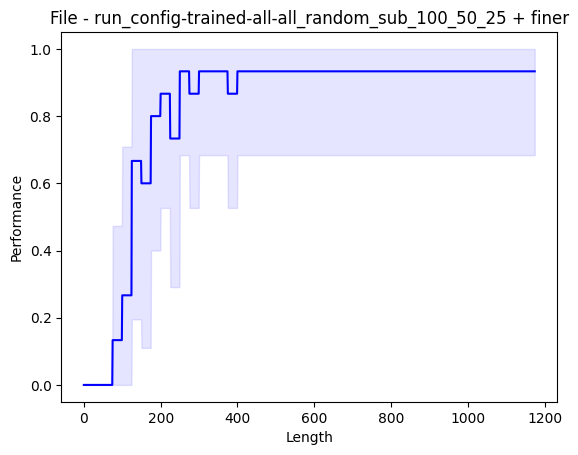

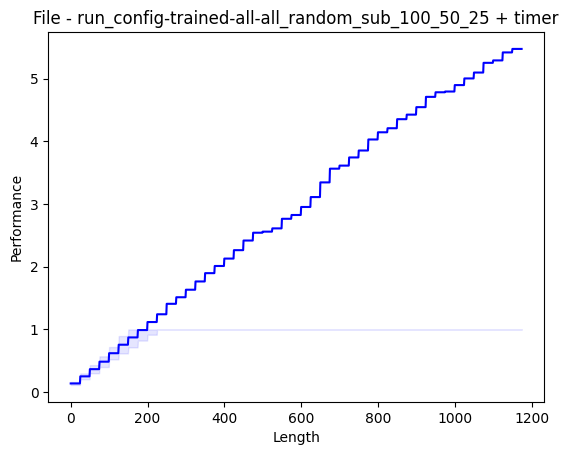

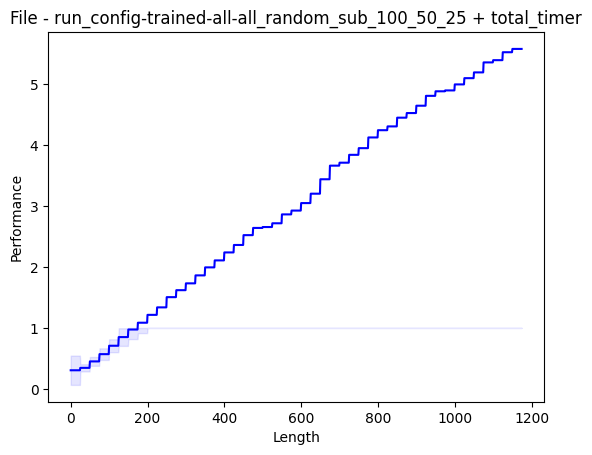

In [3]:
plot_stability("run_config-trained-all-all_random_sub_100_50_25")